In [20]:
import streamlit as st
import polars as pl
import h5py
import numpy as np
from pathlib import Path
from abc import ABC, abstractmethod
import pandas as pd
from st_aggrid import AgGrid, GridOptionsBuilder
from typing import Any

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import dateutil.parser

Found NXentry: /scan
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'/scan/data/amptek_spectrum': (101, 2048), '/scan/data/data': (101, 2048)}
{'/scan/instrument/amptek/data': (101, 2048)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Found NXentry: /scan
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'/scan/data/amptek_spectrum': (101, 2048), '/scan/data/data': (101, 2048)}
{'/scan/instrument/amptek/data': (101, 2048)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Found NXentry: /scan


/scan/apd/data,/scan/apd/mode,/scan/apd2/data,/scan/apd2/mode,/scan/bpm1/attenuator/foilpos,/scan/bpm1/attenuator/type,/scan/bpm1/depends_on,/scan/bpm1/mode,/scan/bpm2/attenuator/foilpos,/scan/bpm2/attenuator/type,/scan/bpm2/depends_on,/scan/bpm2/mode,/scan/bpm3/attenuator/foilpos,/scan/bpm3/attenuator/type,/scan/bpm3/depends_on,/scan/bpm3/mode,/scan/bpm4/attenuator/foilpos,/scan/bpm4/attenuator/type,/scan/bpm4/depends_on,/scan/bpm4/mode,/scan/data/alpha_pos,/scan/data/amptek_roi1,/scan/data/amptek_roi2,/scan/data/amptek_roi3,/scan/data/amptek_roi4,/scan/data/amptek_spectrum,/scan/data/apd,/scan/data/apd2,/scan/data/beta_pos,/scan/data/data,/scan/data/epoch,/scan/data/exp_dmy01,/scan/data/exp_t01,/scan/data/ion1,/scan/data/ion2,/scan/data/ion_bl,/scan/data/lom_foil,…,/scan/instrument/table_a/transformation/h1,/scan/instrument/table_a/transformation/h2,/scan/instrument/table_a/transformation/vc,/scan/instrument/table_a/transformation/vl,/scan/instrument/table_a/transformation/vr,/scan/instrument/table_b/depends_on,/scan/instrument/table_b/transformation/h1,/scan/instrument/table_b/transformation/h2,/scan/instrument/table_b/transformation/trans,/scan/instrument/table_b/transformation/vc,/scan/instrument/table_b/transformation/vl,/scan/instrument/table_b/transformation/vr,/scan/ion1/data,/scan/ion1/mode,/scan/ion2/data,/scan/ion2/mode,/scan/ion_bl/data,/scan/ion_bl/mode,/scan/lom_foil_vfc/data,/scan/lom_foil_vfc/mode,/scan/program_name,/scan/sample/chemical_formula,/scan/sample/depends_on,/scan/sample/lisa_sample_stage/goniy,/scan/sample/lisa_sample_stage/salign,/scan/sample/lisa_sample_stage/sphi,/scan/sample/lisa_sample_stage/sth,/scan/sample/lisa_sample_stage/sx,/scan/sample/lisa_sample_stage/sy,/scan/sample/lisa_sample_stage/sz,/scan/sample/name,/scan/sample/transformations/goni_l,/scan/sample/transformations/goni_u,/scan/start_time,/scan/title,filename,time_series_calc
object,str,object,str,object,str,str,str,object,str,str,str,object,str,str,str,object,str,str,str,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,…,object,object,object,object,object,str,object,object,object,object,object,object,object,str,object,str,object,str,object,str,str,str,str,object,object,object,object,object,object,object,str,object,object,str,str,str,list[f64]
[173383. 173175. 173747. 173701. 172400. 173174. 174400. 174629. 173705. 173600. 172595. 173256. 172851. 173130. 174276. 174668. 174659. 176121. 175952. 175457. 175242. 174118. 175870. 175609. 176323. 175197. 176120. 174973. 175112. 174696. 175592. 176309. 175945. 176325. 175785. 175126. 175853. 175338. 174657. 176657. 175968. 175408. 175070. 174963. 174613. 173803. 172812. 173735. 174683. 174211. 173304. 174362. 173345. 174096. 172603. 173915. 175199. 174510. 173681. 173751. 172846. 173560. 173682. 172925. 173814. 174544. 173718. 173502. 173218. 173131. 173041. 172147. 173129. 174412. 173320. 174132. 173970. 173712. 173622. 174187. 173973. 174877. 175724. 175451. 175361. 174851. 174808. 174740. 173625. 173847. 175976. 174951. 174783. 174412. 174447. 173892. 173367. 172636. 175357. 174892. 174674.],"""monitor""",[173383. 173175. 173747. 173701. 172400. 173174. 174400. 174629. 173705. 173600. 172595. 173256. 172851. 173130. 174276. 174668. 174659. 176121. 175952. 175457. 175242. 174118. 175870. 175609. 176323. 175197. 176120. 174973. 175112. 174696. 175592. 176309. 175945. 176325. 175785. 175126. 175853. 175338. 174657. 176657. 175968. 175408. 175070. 174963. 174613. 173803. 172812. 173735. 174683. 174211. 173304. 174362. 173345. 174096. 172603. 173915. 175199. 174510. 173681. 173751. 172846. 173560. 173682. 172925. 173814. 174544. 173718. 173502. 173218. 173131. 173041. 172147. 173129. 174412. 173320. 174132. 173970. 173712. 173622. 174187. 173973. 174877. 175724. 175451. 175361. 174851. 174808. 174740. 173625. 173847. 175976. 174951. 174783. 174412. 174447. 173892. 173367. 172636. 175357. 174892. 174674.],"""monitor""",[22

[]


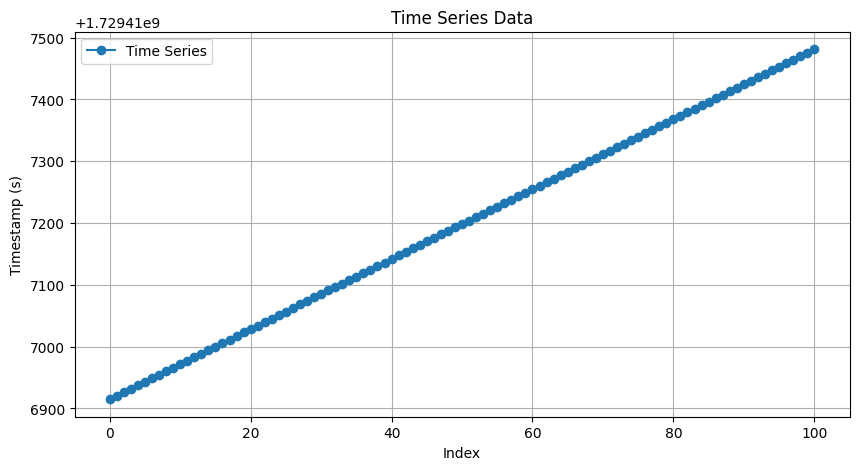

In [31]:
class NexusDataProcessor:
    def __init__(self):
        self.data = None

    def extract_data(self, h5_obj: h5py.Group, path: str = "/", data_dict: dict | None = None) -> dict:
        if data_dict is None:
            data_dict = {}
            
        shape_dict = {}
        for key in h5_obj.keys():
            full_path = f"{path}{key}"
            item = h5_obj[key]
            
            if isinstance(item, h5py.Group):
                self.extract_data(item, full_path + "/", data_dict)
            elif isinstance(item, h5py.Dataset):
                try:
                    data = item[()]
                    if isinstance(data, np.ndarray):
                        data_dict[full_path] = data
                        if data.ndim == 2:
                            shape_dict[full_path] = data.shape  # Store shape if it's 2D
                    elif isinstance(data, (bytes, bytearray)):
                        data_dict[full_path] = data.decode("utf-8", errors="ignore")  # Avoid decoding errors
                    else:
                        data_dict[full_path] = data
                except Exception as e:
                    data_dict[full_path] = f"Error: {e}"
        print(shape_dict)
        return data_dict

    def find_nxentry(self, h5_obj, path="/"):
        """Recursively find the NXentry group dynamically."""
        for key in h5_obj.keys():
            full_path = f"{path}{key}"
            item = h5_obj[key]
            
            if isinstance(item, h5py.Group):
                if item.attrs.get("NX_class") in [b"NXentry", "NXentry"]:
                    print(f"Found NXentry: {full_path}")
                    return item, full_path
                # Recursively search in sub-groups **only if item is a group**
                result = self.find_nxentry(item, full_path + "/")
                if result[0]:
                    return result
        
        return None, None

    def process_single_file(self, file_path: Path) -> dict:
        with h5py.File(file_path, "r") as f:
            nxentry_group, nxentry_path = self.find_nxentry(f)
            if not nxentry_group:
                raise ValueError("No NXentry found in file. Ensure the file is correctly structured.")
            
            data_dict = self.extract_data(nxentry_group, nxentry_path + "/")
            data_dict["filename"] = file_path.name
            return data_dict

    def process_multiple_files(self, file_paths: list | Path) -> pl.DataFrame:
        if isinstance(file_paths, Path):
            file_paths = [file_paths]  # Convert to a list if it's a single Path
        
        all_data = [self.process_single_file(fp) for fp in file_paths]
        return pl.DataFrame(all_data)


    def extract_time_series(self, file_path: Path, df: pl.DataFrame) -> pl.DataFrame:
        with h5py.File(file_path, "r") as f:
            nxentry_group, _ = self.find_nxentry(f)
            if not nxentry_group:
                raise ValueError("No NXentry found in file.")
            
            time_data = {}
            if "/scan/start_time" in nxentry_group:
                time_data["start_time"] = nxentry_group["/scan/start_time"][()].decode("utf-8")
            if "/scan/end_time" in nxentry_group:
                time_data["end_time"] = nxentry_group["/scan/end_time"][()].decode("utf-8")
            if "/scan/data/epoch" in nxentry_group:
                time_data["epoch"] = nxentry_group["/scan/data/epoch"][()]

        if time_data:
            start_time_str = df["/scan/start_time"].to_list()[0]
            end_time_str = df["/scan/end_time"].to_list()[0]
            epoch = np.array(df["/scan/data/epoch"].to_list()[0], dtype=np.float64)

            # Convert start_time and end_time to Unix timestamps
            start_time = dateutil.parser.isoparse(start_time_str).timestamp()
            end_time = dateutil.parser.isoparse(end_time_str).timestamp()

            # Use epoch directly as absolute timestamps
            time_series_calc = np.array(epoch, dtype=np.float64)

            # Ensure consistency with end_time
            if not np.isclose(time_series_calc[-1], end_time, atol=1e-6):
                raise ValueError("Epoch values do not match end_time!")

            # Convert the array to a single element list to match DataFrame row structure
            df = df.with_columns(pl.lit(time_series_calc.tolist()).alias("time_series_calc"))
        
        return df
    
    def list_groups(self, h5_obj, path="/"):
        """Recursively list all groups and their attributes in the file."""
        for key in h5_obj.keys():
            full_path = f"{path}{key}"
            item = h5_obj[key]

            if isinstance(item, h5py.Group):
                print(f"Group: {full_path}, Attributes: {dict(item.attrs)}")
                self.list_groups(item, full_path + "/")  # Recurse into sub-groups


# Define file path
file_path = Path("/Users/lotzegud/P08/fio_nxs_and_cmd_tool/nai_250mm_02348.nxs")

# Initialize processor
processor = NexusDataProcessor()


data_dict = processor.process_single_file(file_path)

df= processor.process_multiple_files(file_path)

df= processor.extract_time_series(file_path, df)

display(df)

def get_2d_columns(df: pl.DataFrame) -> list[str]:
    """Identify columns containing 2D data."""
    two_d_columns = []
    for col in df.columns:
        # Check if the column contains lists of lists (2D arrays)
        if df[col].dtype == pl.List:
            sample_value = df[col].to_list()[0]  # Get the first value in the column
            if isinstance(sample_value, list) and any(isinstance(item, list) for item in sample_value):
                two_d_columns.append(col)
    return two_d_columns

a= get_2d_columns(df)
print(a)



def plot_time_series(df: pl.DataFrame):
    """Plot the time series extracted from the dataset."""
    if "time_series_calc" not in df.columns:
        raise ValueError("time_series_calc column is missing in DataFrame.")
    
    time_series = np.array(df["time_series_calc"].to_list()[0], dtype=np.float64)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, marker="o", linestyle="-", label="Time Series")
    plt.xlabel("Index")
    plt.ylabel("Timestamp (s)")
    plt.title("Time Series Data")
    plt.legend()
    plt.grid()
    #plt.show()

plot_time_series(df)
